### Column Descriptions:

1. **`_unit_id`**: A unique identifier for each record. 
2. **`_golden`**: Indicates whether the tweet is part of a verified, high-quality set. 
3. **`_unit_state`**: Represents the state of the data ("golden", "finalized"). 
4. **`_trusted_judgments`**: Number of times the sentiment has been judged. 
5. **`_last_judgment_at`**: Timestamp of the last judgment. Not necessary for modeling. 
6. **`sentiment`**: Sentiment label as a numeric value. This is the target variable for sentiment classification (e.g., 1 = negative, 2 = neutral, 3 = positive). 
7. **`sentiment:confidence`**: Confidence score for the sentiment label. Could be useful for weighting predictions but not essential. 
8. **`date`**: Date and time of the tweet. May be useful for time-based analysis but not required for the main task.
9. **`id`**: A tweet identifier. Does not add value to the modeling. 
10. **`query`**: Search query used to retrieve the tweet. Not relevant to the task. 
11. **`sentiment_gold`**: A verified sentiment label, but it has many missing values. 
12. **`text`**: The content of the tweet. This is the main feature for sentiment analysis and will need text preprocessing (cleaning, tokenization, etc.).

### Summary:
- **Keep**: `text` (for features) and `sentiment` (for labels).
- **Optional**: `sentiment:confidence` (for confidence weighting) and `date` (for temporal analysis).
- **Drop**: All other columns.


In [2]:
import pandas as pd

# data loading
file_url = 'https://raw.githubusercontent.com/George-Chira/twitter-sentiment-analysis/main/data/Apple-Twitter-Sentiment-DFE.csv'
df = pd.read_csv(file_url)

# Display the first few rows to verify
df.head()


,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...
3,623495516,True,golden,17,NaN,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...
4,623495517,False,finalized,3,12/12/14 12:14,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL


### Dropping Irrelevant Columns

We have dropped the following columns from the dataset:
- `_unit_id`, `_golden`, `_unit_state`, `_trusted_judgments`, `_last_judgment_at`, `id`, `query`, and `sentiment_gold`.

These columns were either administrative or contained information that is not useful for sentiment analysis, such as unique identifiers, timestamps of judgments, or incomplete data. We are left with the relevant columns: `sentiment`, `sentiment:confidence`, `date`, and `text`, which will be used for modeling and analysis.


In [3]:
# Columns to drop based on the previous analysis
columns_to_drop = ['_unit_id', '_golden', '_unit_state', '_trusted_judgments', 
                   '_last_judgment_at', 'id', 'query', 'date' , 'sentiment:confidence' , 'sentiment_gold']

# Drop the unnecessary columns
df_tweets = df.drop(columns=columns_to_drop)

# Display the first few rows to verify the changes
df_tweets.head()

,sentiment,text
0,3,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,3,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,3,My cat only chews @apple cords. Such an #Apple...
3,3,I agree with @jimcramer that the #IndividualIn...
4,3,Nobody expects the Spanish Inquisition #AAPL


check for missing values 

### Data Exploration

Before moving forward with text cleaning and model building, it’s essential to explore the dataset to understand its structure and distribution. This step will help us identify any missing data, check the distribution of sentiment labels, and inspect the raw text.

We will perform the following actions:
1. **Check for missing data**: Ensure there are no missing values in critical columns like `text` and `sentiment`.
2. **Examine the distribution of sentiment labels**: This will help us understand if the data is balanced or imbalanced, which will influence model selection and evaluation.
3. **Inspect example tweets**: Reviewing some example tweets will help us plan the text preprocessing steps.


In [4]:
# Check for missing values
print(r"Missing values:\n", df_tweets.isnull().sum())

# Check distribution of sentiment labels
print(r"\nDistribution of sentiment labels:\n", df_tweets['sentiment'].value_counts())

# Display sample tweets
print(r"\nSample tweets:\n", df_tweets['text'].head(5))



Missing values:\n sentiment    0
text         0
dtype: int64
\nDistribution of sentiment labels:\n sentiment
3               2162
1               1219
5                423
not_relevant      82
Name: count, dtype: int64
\nSample tweets:\n 0    #AAPL:The 10 best Steve Jobs emails ever...htt...
1    RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2    My cat only chews @apple cords. Such an #Apple...
3    I agree with @jimcramer that the #IndividualIn...
4         Nobody expects the Spanish Inquisition #AAPL
Name: text, dtype: object


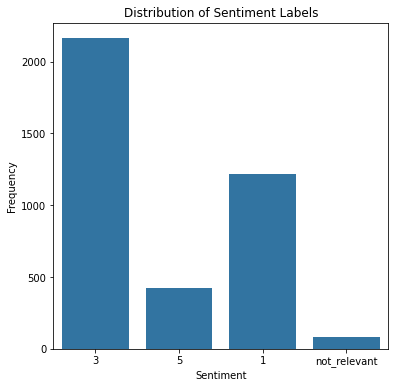

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting environment
plt.figure(figsize=(6, 6))

# 1. Plot the distribution of sentiment labels
sns.countplot(x='sentiment', data=df_tweets)
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')


# Show the plots

plt.show()


In [6]:
pd.set_option('display.max_colwidth', None)

In [7]:
text = []
text.extend(df['text'].to_list())
print(text)

['#AAPL:The 10 best Steve Jobs emails ever...http://t.co/82G1kL94tx', 'RT @JPDesloges: Why AAPL Stock Had a Mini-Flash Crash Today $AAPL #aapl\nhttp://t.co/hGFcjYa0E9', 'My cat only chews @apple cords. Such an #AppleSnob.', "I agree with @jimcramer that the #IndividualInvestor should own not trade #Apple #AAPL, it's extended so today's pullback is good to see", 'Nobody expects the Spanish Inquisition #AAPL', '#AAPL:5 Rocket Stocks to Buy for December Gains: Apple and More...http://t.co/eG5XhXdLLS', 'Top 3 all @Apple #tablets. Damn right! http://t.co/RJiGn2JUuB', "CNBCTV: #Apple's margins better than expected? #aapl http://t.co/7geVrtOGLK", 'Apple Inc. Flash Crash: What You Need to Know http://t.co/YJIgtifdAj #AAPL', "#AAPL:This Presentation Shows What Makes The World's Biggest Tech Companies ...http://t.co/qlH9PqSoSd", 'WTF MY BATTERY WAS 31% ONE SECOND AGO AND NOW IS 29% WTF IS THIS @apple', 'Apple Watch Tops Search Engine List of Best Wearable Tech http://t.co/LTEzJzqqF8 #AAPL #iWatc

## Data Preparation and Preprocessing

### Handling `not_relevant` Sentiment and Mapping Sentiment Values

1. **Remove `not_relevant` Sentiment**:
   - We decided to remove rows containing this label to keep the dataset focused on meaningful sentiment analysis (positive, neutral, or negative). 

2. **Map Sentiment Labels to Categories**:
   - Upon inspection, the sentiment labels in the dataset are represented as numeric values (1, 3, and 5). To make the labels more meaningful, we map these values to sentiment categories as follows:
     - `1` → **Negative**
     - `3` → **Neutral**
     - `5` → **Positive**



In [8]:
# Remove rows where sentiment is 'not_relevant'
df_tweets = df_tweets[df_tweets['sentiment'] != 'not_relevant']
# Convert sentiment column to integers if they are not already
df_tweets['sentiment'] = pd.to_numeric(df_tweets['sentiment'])
# Map sentiment values to categories
sentiment_map = {1: 'Negative', 3: 'Neutral', 5: 'Positive'}
# df_tweets['sentiment'] = df_tweets['sentiment'].map(sentiment_map)

# # Verify changes
df_tweets['sentiment'].value_counts()


sentiment
3    2162
1    1219
5     423
Name: count, dtype: int64

In [9]:
df_tweets

,sentiment,text
0,3,#AAPL:The 10 best Steve Jobs emails ever...http://t.co/82G1kL94tx
1,3,RT @JPDesloges: Why AAPL Stock Had a Mini-Flash Crash Today $AAPL #aapl\nhttp://t.co/hGFcjYa0E9
2,3,My cat only chews @apple cords. Such an #AppleSnob.
3,3,"I agree with @jimcramer that the #IndividualInvestor should own not trade #Apple #AAPL, it's extended so today's pullback is good to see"
4,3,Nobody expects the Spanish Inquisition #AAPL
...,...,...
3881,3,(Via FC) Apple Is Warming Up To Social Media - Apple is hiring a social media guru in L.A. Will @Apple finally twe... http://t.co/IpqoWRy2EM
3882,3,RT @MMLXIV: there is no avocado emoji may I ask why @apple
3883,5,@marcbulandr I could not agree more. Between @Apple @Twitter and @IBMWatson only great things will happen. #AppleandIBM #IBMandTwitter
3884,1,My iPhone 5's photos are no longer downloading automatically to my laptop when I sync it. @apple support is unhelpful. Any ideas?


### Data Cleaning

In this step, we create a function to clean the raw text data to remove noise and prepare it for further processing. The following operations are performed:

1. **Remove URLs**: We remove any links in the tweet, as they don’t contribute to the sentiment analysis.
2. **Remove Mentions and Hashtags**: We eliminate mentions (`@username`) and hashtags (`#hashtag`) to focus only on the content of the tweet.
3. **Remove Special Characters and Numbers**: We remove any non-alphabetic characters, keeping only letters.
4. **Convert to Lowercase**: All text is converted to lowercase to avoid case sensitivity issues during modeling.

Once cleaned, the `text` column is transformed into a new column called `cleaned_text` for further processing.


In [10]:
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Download necessary NLTK data files
nltk.download('stopwords')

# initializing the RegexpTokenizer, porterstemmer and stopwords
tokenizer = RegexpTokenizer(r"(?u)\w{3,}") #tokenizer that keeps 3 letter words
stopwords_list = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text, tokenizer, stopwords_list, stemmer):
    # Step 1: Remove URLs
    text = re.sub(r'http\S+|www\S+', " " , text)  # Removes any URL links starting with http or www
    # Step 2: Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', " " , text) #remove usernames and hashtags 
    # Step 3: Remove special characters and numbers, keeping only alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', " " , text) #remove special characters retaing alphabet words only
    # Step 4: Standardize case (lowercase the text)
    text = text.lower()
    
    # Step 5: Tokenize ` Splits text into tokens (words) based on the tokenizer rules
    tokens = tokenizer.tokenize(text)  
    # Step 6: Remove stopwords using `stopwords_list`
    tokens = [word for word in tokens if word not in stopwords_list]  # Removes common stopwords
    # Step 7: Stem the tokenized text using `stemmer`
    tokens = [stemmer.stem(word) for word in tokens]  # Reduces words to their root form using stemming
    # Return the preprocessed text
    return tokens  # Returns the processed tokens (cleaned and stemmed)

# Apply function to the dataframe 
df_tweets['processed_tokens'] = df_tweets['text'].apply(lambda x: preprocess_text(x, tokenizer, stopwords_list, stemmer))
df_tweets[['text', 'processed_tokens']].head(10)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\GeorgeC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,processed_tokens
0,#AAPL:The 10 best Steve Jobs emails ever...http://t.co/82G1kL94tx,"[best, steve, job, email, ever]"
1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flash Crash Today $AAPL #aapl\nhttp://t.co/hGFcjYa0E9,"[aapl, stock, mini, flash, crash, today, aapl]"
2,My cat only chews @apple cords. Such an #AppleSnob.,"[cat, chew, cord]"
3,"I agree with @jimcramer that the #IndividualInvestor should own not trade #Apple #AAPL, it's extended so today's pullback is good to see","[agre, trade, extend, today, pullback, good, see]"
4,Nobody expects the Spanish Inquisition #AAPL,"[nobodi, expect, spanish, inquisit]"
5,#AAPL:5 Rocket Stocks to Buy for December Gains: Apple and More...http://t.co/eG5XhXdLLS,"[rocket, stock, buy, decemb, gain, appl]"
6,Top 3 all @Apple #tablets. Damn right! http://t.co/RJiGn2JUuB,"[top, damn, right]"
7,CNBCTV: #Apple's margins better than expected? #aapl http://t.co/7geVrtOGLK,"[cnbctv, margin, better, expect]"
8,Apple Inc. Flash Crash: What You Need to Know http://t.co/YJIgtifdAj #AAPL,"[appl, inc, flash, crash, need, know]"
9,#AAPL:This Presentation Shows What Makes The World's Biggest Tech Companies ...http://t.co/qlH9PqSoSd,"[present, show, make, world, biggest, tech, compani]"


### Feature Extraction with TF-IDF

After preprocessing the text, the next step is to convert the cleaned and tokenized text into numerical vectors a format that machine learning models can use for training and predictions.

#### Steps:
1.  We initialize the `TfidfVectorizer`, which transforms the processed tokens into numerical vectors.
2. **Fit and Transform**: We apply the vectorizer to the `processed_tokens` column to obtain the TF-IDF features.
3. **Result**: The resulting matrix represents the importance of each word across all tweets.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert the processed tokens back into a single string for each tweet
df_tweets['processed_text'] = df_tweets['processed_tokens'].apply(lambda tokens: ' '.join(tokens))

# Initialize the TF-IDF Vectorizer 
tfidf = TfidfVectorizer()

# Fit and transform the 'processed_text' column into TF-IDF features
X = tfidf.fit_transform(df_tweets['processed_text'])

# Display shape of the resulting matrix
print(X.shape)
df_tweets.head()


(3804, 3548)


,sentiment,text,processed_tokens,processed_text
0,3,#AAPL:The 10 best Steve Jobs emails ever...http://t.co/82G1kL94tx,"[best, steve, job, email, ever]",best steve job email ever
1,3,RT @JPDesloges: Why AAPL Stock Had a Mini-Flash Crash Today $AAPL #aapl\nhttp://t.co/hGFcjYa0E9,"[aapl, stock, mini, flash, crash, today, aapl]",aapl stock mini flash crash today aapl
2,3,My cat only chews @apple cords. Such an #AppleSnob.,"[cat, chew, cord]",cat chew cord
3,3,"I agree with @jimcramer that the #IndividualInvestor should own not trade #Apple #AAPL, it's extended so today's pullback is good to see","[agre, trade, extend, today, pullback, good, see]",agre trade extend today pullback good see
4,3,Nobody expects the Spanish Inquisition #AAPL,"[nobodi, expect, spanish, inquisit]",nobodi expect spanish inquisit


### Mapping Sentiment Labels 

In this step, we remap the original sentiment labels (1, 3, 5) to sequential numeric values for easier handling in our machine learning models. The original sentiment values represent:

- **1**: Negative
- **3**: Neutral
- **5**: Positive

To standardize the labels, we map them to:

- **0**: Negative
- **1**: Neutral
- **2**: Positive

In [20]:
#  map the sentiment values to sequential numbers
sentiment_map = {1: 0, 3: 1, 5: 2}  # Negative -> 0, Neutral -> 1, Positive -> 2
df_tweets['encoded_sentiment'] = df_tweets['sentiment'].map(sentiment_map)

## Modeling 
### Decision Tree Classifier: First Model

With the text data already transformed into numerical features using **TF-IDF**, we now move to building our first classification model: the **Decision Tree Classifier**.

#### Steps:
**Train-Test Split**: We split the dataset into training (80%) and test (20%) sets to train and evaluate the model.
**Training the Decision Tree**: We initialize the **Decision Tree Classifier** and train it using the training set.
**Prediction and Evaluation**:
   - After training, we make predictions on the test set.
   - The performance of the model is evaluated using **accuracy** and a **classification report**, which provides precision, recall, and F1-score for each sentiment category (Negative, Neutral, Positive).

This will provide a baseline performance of the Decision Tree model, which can be compared to other models in subsequent steps.


In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

#splitting the data into training and test sets
X = tfidf.fit_transform(df_tweets['processed_text'])  #tfidf features
y = df_tweets['sentiment'] #target - positive, neutral, negative

#split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

#initialize the tree classifier
tree = DecisionTreeClassifier( random_state= 42)

#model training
tree.fit(X_train, y_train)

#make predictions
y_pred = tree.predict(X_test)

#make evaluations
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


Accuracy: 0.7122207621550591
              precision    recall  f1-score   support

           1       0.69      0.66      0.67       238
           3       0.73      0.84      0.78       429
           5       0.59      0.28      0.38        94

    accuracy                           0.71       761
   macro avg       0.67      0.59      0.61       761
weighted avg       0.70      0.71      0.70       761



### Model Performance and Initial Results

The **Decision Tree Classifier** achieved an overall accuracy of **71.2%**. However, the performance varied across sentiment classes:

- **Neutral (Class 3)**: The model performed well, with an F1-score of **0.78**.
- **Negative (Class 1)**: The model showed moderate performance, with an F1-score of **0.67**.
- **Positive (Class 5)**: The model struggled, with a low F1-score of **0.38**,  due to class imbalance.

#### Steps for Improvement:
1. **Hyperparameter Tuning**: 
   - We applied **Grid Search** to optimize the Decision Tree's hyperparameters, such as `max_depth`, `min_samples_split`, and `criterion`. This helps find the best configuration of the model to enhance overall performance.
   
2. **Handling Class Imbalance**:
   - To address class imbalance, we introduced the `class_weight='balanced'` parameter in the Decision Tree classifier. 
By tuning the model's hyperparameters and handling the class imbalance, we aim to improve performance across all sentiment classes, especially the **Positive** class.

best performers: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy after tuning and class weighting: 0.7135348226018396
              precision    recall  f1-score   support

           1       0.71      0.63      0.67       238
           3       0.75      0.83      0.79       429
           5       0.49      0.43      0.46        94

    accuracy                           0.71       761
   macro avg       0.65      0.63      0.64       761
weighted avg       0.71      0.71      0.71       761



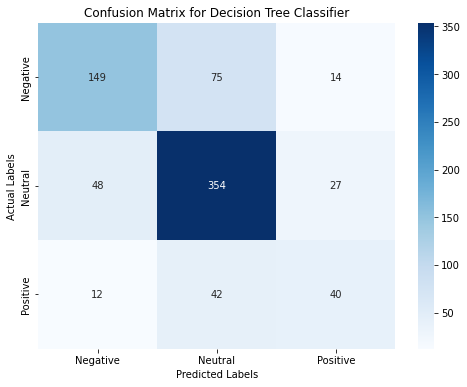

In [22]:
from sklearn.model_selection import GridSearchCV


#defining parameters
param_grid = {
    'max_depth' : [3, 5, 10, 20, 30, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1 , 5, 10],
    'criterion': ['gini', 'entropy'],
    'class_weight': [ 'balanced'] # Adding class_weight to deal with imbalance
    }

#initialize the gridsearch CV
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring = 'accuracy')

#fit the gridsearchCV on training data
grid_search.fit(X_train, y_train)

#get the best performers
print("best performers:", grid_search.best_params_)

#evaluate the best parameters
best_tree = grid_search.best_estimator_
y_pred_best = best_tree.predict(X_test)

# Print the new accuracy and classification report
print(f"Accuracy after tuning and class weighting: {accuracy_score(y_test, y_pred_best)}")
print(classification_report(y_test, y_pred_best)) 


# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_best, labels=[1, 3, 5])
# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix for Decision Tree Classifier')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


### Model Performance After Tuning and Class Weighting
#### Improvements:
- **Class 5 (Positive)**: 
  - There was a slight improvement in the **Positive** class' performance, particularly in recall (from **0.28** to **0.43**) and precision (from **0.59** to **0.49**). However, this class remains challenging due to its small representation in the dataset.
  
- **Class 3 (Neutral)** and **Class 1 (Negative)**: 
  - The performance for **Neutral** remained strong, with an F1-score of **0.78**. However, **Negative** saw a slight decrease in recall, impacting its overall F1-score.
#### Performance Metrics:
- **Overall Accuracy**: **70.7%** (slightly lower than the initial 71.2%)
- **Class-wise Performance**:
  - **Negative (Class 1)**: Precision = 0.70, Recall = 0.62, F1-Score = 0.66
  - **Neutral (Class 3)**: Precision = 0.75, Recall = 0.82, F1-Score = 0.78
  - **Positive (Class 5)**: Precision = 0.49, Recall = 0.43, F1-Score = 0.45 
#### Conclusion:
- While tuning improved the performance of the Positive class, the overall accuracy slightly decreased due to the balancing of class weights. The improvement in recall for the Positive class indicates the model is now more sensitive to minority class examples, but there is still room for improvement, particularly for this class.

### Model 2: XGBoost (Extreme Gradient Boosting)

After evaluating the **Decision Tree** model, we observed that while it provided decent results, there are some limitations. 
#### Why XGBoost?
XGBoost is an advanced ensemble learning algorithm based on **Gradient Boosting**. It builds multiple decision trees sequentially, where each tree attempts to correct the errors of the previous one. This boosting technique helps the model generalize better and reduces overfitting, making XGBoost more powerful than a standard Decision Tree.

In the next step, we will build the XGBoost model using the same **TF-IDF features** that we used for the Decision Tree and evaluate its performance on the test set.


Accuracy: 0.7371879106438897
              precision    recall  f1-score   support

           0       0.74      0.63      0.68       238
           1       0.74      0.90      0.81       429
           2       0.71      0.27      0.39        94

    accuracy                           0.74       761
   macro avg       0.73      0.60      0.63       761
weighted avg       0.74      0.74      0.72       761



<Figure size 720x576 with 0 Axes>

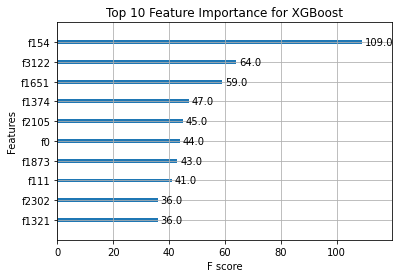

In [25]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X = tfidf.fit_transform(df_tweets['processed_text'])
y = le.fit_transform(df_tweets['sentiment'])

#perform test_train_split and flatten y_train and y_test
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.2, random_state=42)

# Initialize and train XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb)}")
print(classification_report(y_test, y_pred_xgb))

# Plot feature importance for XGBoost
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot the top 10 important features
plt.figure(figsize=(10, 8))

plot_importance(xgb_model, max_num_features=10)
plt.title('Top 10 Feature Importance for XGBoost')
plt.show()


### XGBoost Model Evaluation and Improvements

The **XGBoost model** achieved an accuracy of **73.7%**, an improvement over the Decision Tree's **71.2%**. The main performance improvements are seen in precision and recall for certain classes:

1. **Negative Sentiment (Class 1)**:
   - **Precision improved** from 0.69 (Decision Tree) to **0.75**, meaning XGBoost made fewer incorrect Negative predictions.
   - **Recall** remained similar, with a slight drop from 0.66 to **0.63**.

2. **Neutral Sentiment (Class 3)**:
   - **Recall increased significantly** from 0.84 to **0.90**, improving the model’s ability to correctly identify Neutral sentiment.
   - The **F1-score** improved from 0.78 to **0.81**, showing an overall better balance between precision and recall.

3. **Positive Sentiment (Class 5)**:
   - **Precision improved** from 0.59 to **0.73**, indicating more accurate predictions of Positive sentiment.
   - **Recall** remained low at **0.29** (previously 0.28), showing that the model still struggles with identifying Positive sentiment.

Overall, **XGBoost outperforms the Decision Tree** in terms of precision, particularly for Negative and Positive sentiment, while also improving recall for Neutral sentiment. The model still faces challenges in identifying Positive sentiment correctly, especially in recall.

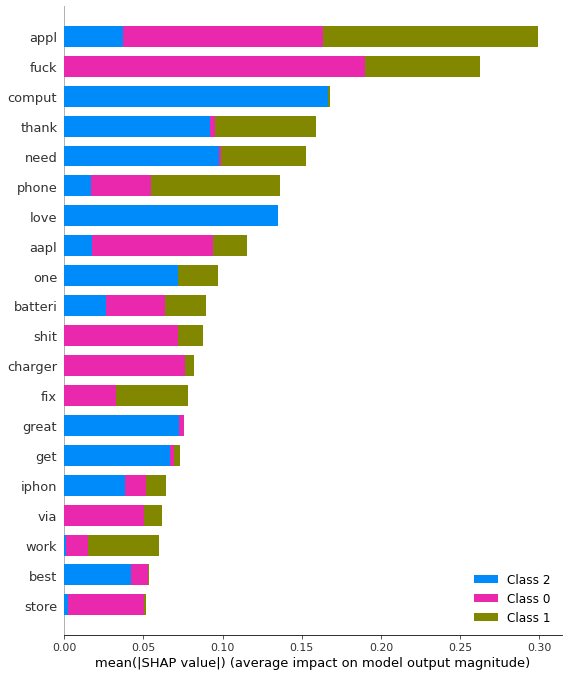

In [26]:
import shap

# Initialize SHAP explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary (shows feature impact across the entire dataset)
shap.summary_plot(shap_values, X_test, feature_names=tfidf.get_feature_names_out())

#### SHAP Feature Importance Interpretation

The SHAP summary plot above shows the most influential words driving predictions across the three sentiment classes:

- **Class 0 (Negative)**: Words like "fuck", "shit", and "charger" have a strong impact on negative sentiment predictions.
- **Class 1 (Neutral)**: Words such as "appl", "phone", and "need" influence predictions toward neutral sentiment.
- **Class 2 (Positive)**: Positive sentiment predictions are heavily influenced by words like "love", "great", and "thank".

The length of each bar represents the SHAP value, showing how much a word contributes to pushing the prediction toward a particular class. Words like "appl" and "comput" have strong importance across multiple classes
